# Model Accuracy

## Human behaviour

In [22]:
from bids import BIDSLayout, BIDSLayoutIndexer
import pandas as pd

# Load human data (40 good subject)
subject_list = [2, 4, 5, 6, 7, 8, 9, 11, 12, 13, 15,
                17, 18, 19, 21, 23, 24, 25, 26, 27,
                28, 30, 34, 35, 36, 38, 39, 40, 41,
                42, 45, 46, 50, 51, 54, 55, 56, 61,
                64, 65]
try:
    human_df = pd.read_csv('../results/human_behaviour.csv')

except:
    indexer = BIDSLayoutIndexer(validate=False, index_metadata=False)
    layout = BIDSLayout('/home/lukeh/hpcworking/shared/projects/LST7T/data/bids/', indexer=indexer)
    human_df = pd.DataFrame()
    for subject in subject_list:
        s = str(subject).zfill(2)
        all_files = layout.get(subject=s, task='LST',suffix='events', return_type='filename')
        if len(all_files) == 3:
            _df = pd.concat((pd.read_csv(f, delimiter='\t') for f in all_files), ignore_index=True)
            _df['subject'] = subject
            human_df = pd.concat([human_df, _df])
        else:
            print(len(all_files))
            print(subject)
    human_df.to_csv('../results/human_behaviour.csv', index=False)

# APM
fMRI_path = '/home/lukeh/LabData/Lab_LucaC/Luke/Backups/hpc_backups/projects/LST7T/data/bids/'
df_APM = pd.read_csv(f"{fMRI_path}phenotype/APM.tsv", delimiter='\t')
df_APM.APM_set1_accuracy = (df_APM.APM_set1_accuracy / 12) * 100
df_APM.APM_set2_accuracy = (df_APM.APM_set2_accuracy / 36) * 100
df_APM[["_", "subject"]] = df_APM["participant_id"].str.split("-", expand=True)
df_APM["subject"] = df_APM["subject"].astype(int)
df_APM = df_APM.loc[df_APM.subject.isin(subject_list)]

## Human stats

In [23]:
import pingouin as pg
data = human_df.groupby(["trial_type", "subject"]).mean(numeric_only=True).reset_index()
data = data.loc[data.trial_type != "Null"]

# ANOVA
display(pg.rm_anova(data=data, dv="accuracy", within="trial_type", subject="subject"))

# Follow-up
for cond_a, cond_b in zip(["Binary", "Binary", "Ternary"],
                           ["Ternary", "Quaternary", "Quaternary"]):
    print(cond_a, cond_b)
    a = data.loc[data.trial_type == cond_a, "accuracy"].values
    b = data.loc[data.trial_type == cond_b, "accuracy"].values
    print("\t means / sds = ")
    print("\t", (a.mean()*100).round(2), "/", (a.std()*100).round(2))
    print("\t", (b.mean()*100).round(2), "/", (b.std()*100).round(2))
    display(pg.ttest(a, b, paired=True))

# IQ correlation
print("IQ correlation")
x = df_APM.APM_set2_accuracy.values
y = data.loc[data.trial_type == "Quaternary", "accuracy"].values
display(pg.corr(x, y, method="spearman"))

/home/lukeh/miniconda3/envs/LSTANN/lib/python3.9/site-packages/pingouin/parametric.py:551: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  ss_resall = grp_with.apply(lambda x: (x - x.mean()) ** 2).sum()


,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,trial_type,2,78,55.294367,1.113206e-15,1.011064e-10,0.429111,0.628952,False,0.410054,4.405251e-08


Binary Ternary
	 means / sds = 
	 96.67 / 4.13
	 87.01 / 11.01


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,6.778575,39,two-sided,4.321586e-08,"[0.07, 0.13]",1.146013,3.233e+05,1.0


Binary Quaternary
	 means / sds = 
	 96.67 / 4.13
	 66.25 / 22.46


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,8.788167,39,two-sided,8.691685e-11,"[0.23, 0.37]",1.859937,1.161e+08,1.0


Ternary Quaternary
	 means / sds = 
	 87.01 / 11.01
	 66.25 / 22.46


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,5.942964,39,two-sided,6.215461e-07,"[0.14, 0.28]",1.159115,2.653e+04,1.0


IQ correlation


,n,r,CI95%,p-val,power
spearman,40,0.47982,"[0.2, 0.69]",0.00173,0.895056


## ANN models

In [24]:
import lstnn.transformer_main as transformer_main
from lstnn.dataset import get_dataset
import torch
import numpy as np
import matplotlib.pyplot as plt


LST_puzzle_ds = get_dataset('../data/nn/puzzle_data_original.csv')

# model parameters
dropout = 0.0
epoch = 4000 # final training step
layer = 4
attnhead = 1
wdecay = 0.0
model_label = 'BERT'
curriculum = 'All'
seeds = [2235, 6312, 6068, 9742, 8880, 2197, 669, 6256, 3309, 2541, 8643, 7785, 195, 6914, 29]

device = 'cpu'

# model params
nblocks = [4]
dropout = 0.0
hidden_size = 160 
learning_rate = 0.0001
training_acc_cutoff = 0.0
cutoff_length = 0  # how many epochs must the model sustain the accuracy cutoff?
last_epoch = 4000
checkpoint_freq = 200
# for epoch in np.arange(0, last_epoch+1, checkpoint_freq):
pe = 'pe-2dpe_'
petype = 'absolute2d'
pestr = '2dpe'
resultdir = f"/home/lukeh/LabData/Lab_LucaC/Luke/projects/LSTNN/data/ito_models/"
modelname = f"model-{model_label}_" \
            f"{pe}" \
            f"nl-{layer}_" \
            f"do-{dropout}_" \
            f"wd-{wdecay}_" \
            f"at-{attnhead}_" \
            f"hs-{hidden_size}_" \
            f"curr-{curriculum}_" \
            f"lr-{learning_rate}_" \
            f"co-{training_acc_cutoff}_" \
            f"col-{cutoff_length}/"
model_str = pestr + '-' + str(attnhead) + 'H'
# _df = df_good_models.loc[(df_good_models.epoch==4000) & (df_good_models.pe==pestr) & (df_good_models.heads==attnhead)]
# if len(_df)<1: continue
df = pd.DataFrame()
for seed in seeds:
    checkpoint = f"s-{seed}_" \
                f"e-{epoch}"
    file = resultdir + modelname + checkpoint +'.csv'
    _df = pd.read_csv(file)
    _df['seed'] = seed
    _df["model"] = "transformer"
    df = pd.concat([df, _df])

In [25]:
resultdir = f"../results/"
#x = "../results/model-ffn/nl-4_do-0_wd-0_hs-160_lr-0.0001_s-195_e-0.csv"
#     ../results/model-ffn/nl-4_do-0_wd-0.1_hs-160_lr-0.0001_s-2235_e-4000.csv'
model_label = "lstm"

modelname = f"model-{model_label}/" \
            f"nl-{layer}_" \
            f"do-0_" \
            f"wd-0_" \
            f"hs-{hidden_size}_" \
            f"lr-{learning_rate}_" \
            f"bidirectionalTrue_" \

for seed in seeds:
    checkpoint = f"s-{seed}_" \
                f"e-{epoch}"
    file = resultdir + modelname + checkpoint +'.csv'
    _df = pd.read_csv(file)
    _df['seed'] = seed
    _df["model"] = "lstm"
    df = pd.concat([df, _df])

In [26]:
resultdir = f"../results/"
#x = "../results/model-ffn/nl-4_do-0_wd-0_hs-160_lr-0.0001_s-195_e-0.csv"
#     ../results/model-ffn/nl-4_do-0_wd-0.1_hs-160_lr-0.0001_s-2235_e-4000.csv'
model_label = "ffn"

modelname = f"model-{model_label}/" \
            f"nl-{layer}_" \
            f"do-0_" \
            f"wd-0_" \
            f"hs-{hidden_size}_" \
            f"lr-{learning_rate}_" 
for seed in seeds:
    checkpoint = f"s-{seed}_" \
                f"e-{epoch}"
    file = resultdir + modelname + checkpoint +'.csv'
    _df = pd.read_csv(file)
    _df['seed'] = seed
    _df["model"] = "ffn"
    df = pd.concat([df, _df])

## ANN stats

In [27]:
df.head()

,epoch,block,loss,accuracy,condition,phase,seed,model
0,0,0,1.406411,0.254300,average,train,2235,transformer
1,0,0,NaN,0.266237,binary,train,2235,transformer
2,0,0,NaN,0.254184,quaternary,train,2235,transformer
3,0,0,NaN,0.243397,ternary,train,2235,transformer
4,0,0,1.389276,0.279297,average,test,2235,transformer


In [28]:
for ann in df.model.unique():
    print(ann)

    for phase in df.phase.unique():
        data = df.loc[(df.epoch == 4000) & (df.model==ann) 
                    & (df.phase==phase)]
        print("\t", phase,":", (data.loc[data.condition=="average", "accuracy"].mean()*100))

    
    # # Test validation against 0
    # print("Test against chance")
    # data = df.loc[(df.epoch == 4000) & (df.model==ann) 
    #         & (df.phase=="validation"), "accuracy"].values
    # display(pg.ttest(data, 0.25))

# Treat the transformer similar to Humans
data = df.loc[(df.epoch == 4000) & (df.model=="transformer") 
        & (df.phase=="validation")]
data = data[data.condition != "average"].groupby(["condition", "seed"]).mean(numeric_only=True).reset_index()
display(pg.friedman(data=data, dv="accuracy", within="condition", subject="seed"))



transformer
	 train : 99.98372395833334
	 test : 98.50911458333333
	 validation : 97.65432098765433
lstm
	 train : 100.0
	 test : 60.89192708333333
	 validation : 55.493827160493815
ffn
	 train : 100.0
	 test : 86.9140625
	 validation : 33.02469135802468


,Source,W,ddof1,Q,p-unc
Friedman,condition,0.382456,2,11.473684,0.003225


In [29]:
# Follow-up
for cond_a, cond_b in zip(["binary", "binary", "ternary"],
                           ["ternary", "quaternary", "quaternary"]):
    print(cond_a, cond_b)
    a = data.loc[data.condition == cond_a, "accuracy"].values
    b = data.loc[data.condition == cond_b, "accuracy"].values
    print("\t means / sds = ")
    print("\t", (a.mean()*100).round(2), "/", (a.std()*100).round(2))
    print("\t", (b.mean()*100).round(2), "/", (b.std()*100).round(2))
    display(pg.ttest(a, b, paired=True))

binary ternary
	 means / sds = 
	 99.07 / 3.46
	 97.78 / 8.31


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.0,14,two-sided,0.334282,"[-0.01, 0.04]",0.196618,0.403,0.109523


binary quaternary
	 means / sds = 
	 99.07 / 3.46
	 96.11 / 9.56


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.785669,14,two-sided,0.095824,"[-0.01, 0.07]",0.398182,0.94,0.300891


ternary quaternary
	 means / sds = 
	 97.78 / 8.31
	 96.11 / 9.56


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.806243,14,two-sided,0.014007,"[0.0, 0.03]",0.179743,4.228,0.099555


## Plots

### Comparison across ANNs

/tmp/ipykernel_164676/1506199439.py:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["1-vec", "2-vec", "3-vec"])
/tmp/ipykernel_164676/1506199439.py:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["1-vec", "2-vec", "3-vec"])
/tmp/ipykernel_164676/1506199439.py:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["1-vec", "2-vec", "3-vec"])


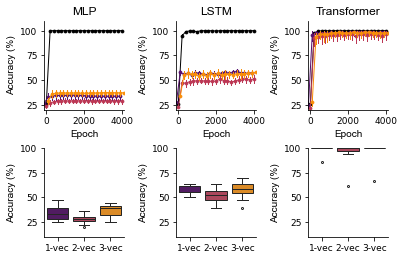

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# generate basic figure
# create figure
fig, axs = plt.subplot_mosaic("""
                              ABC
                              DEF
                              """,
                              figsize=(5.5, 3.5),
                              constrained_layout=True)
model_labels = ["MLP", "LSTM", "Transformer"]
for i, (_ax, model) in enumerate(zip(["A", "B", "C"], 
                                     ["ffn", "lstm", "transformer"])):
    ax = axs[_ax]

    # plot average train
    plot_df = df.loc[(df.model == model) 
                    & (df["phase"] == "train")
                    & (df['condition'] == 'average')].reset_index()
    plot_df["accuracy"] = plot_df["accuracy"] * 100
    sns.pointplot(data=plot_df, ax=ax, markersize=3, linewidth=1,
                x='epoch', y='accuracy', legend=False, color='k')

    # plot condition-wise test
    plot_df = df.loc[(df.model == model) 
                    & (df["phase"] == "validation")
                    & (df['condition'] != 'average')].reset_index()
    plot_df["accuracy"] = plot_df["accuracy"] * 100
    sns.pointplot(data=plot_df, ax=ax, markersize=3, linewidth=1,
                x='epoch', y='accuracy', hue='condition', dodge=1,
                legend=False, palette='inferno')
    
    ax.tick_params(axis='both', which='major', labelsize=9)
    ax.set_title(model_labels[i], fontsize=12, fontname='Arial')
    ax.set_xlabel('Epoch', fontsize=10, fontname='Arial')
    ax.set_ylabel('Accuracy (%)', fontsize=10, fontname='Arial')
    ax.set_xticks(np.arange(0, 21, 10), fontsize=8)
    #ax.set_yticks(np.arange(0, 1, 0.2), fontsize=8)
    ax.set_ylim([20, 110])
    sns.despine(ax=ax)


for i, (_ax, model) in enumerate(zip(["D", "E", "F"], 
                                     ["ffn", "lstm", "transformer"])):
    ax = axs[_ax]

    # plot condition-wise test
    plot_df = df.loc[(df.model == model) 
                    & (df["epoch"] == 4000)
                    & (df["phase"] == "validation")
                    & (df['condition'] != 'average')].reset_index()
    plot_df["accuracy"] = plot_df["accuracy"] * 100
    sns.boxplot(data=plot_df, ax=ax, linewidth=1, fliersize=2,
                x='condition', y='accuracy', hue='condition',
                legend=False, palette='inferno')
    
    ax.tick_params(axis='both', which='major', labelsize=9)
    ax.set_ylabel('Accuracy (%)', fontsize=10, fontname='Arial')
    ax.set_xlabel("")
    ax.set_xticklabels(["1-vec", "2-vec", "3-vec"])
    #ax.set_yticks(np.arange(10, 100, 20))
    ax.set_ylim([10, 100])
    sns.despine(ax=ax)

plt.show()

0.3876478461357779


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_164676/3164850363.py:121: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.savefig("../figures/model_performance.svg", dpi=1200)
/tmp/ipykernel_164676/3164850363.py:121: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.savefig("../figures/model_performance.svg", dpi=1200)
/tmp/ipykernel_164676/3164850363.py:121: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.savefig("../figure

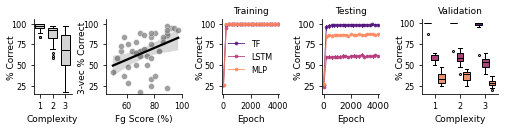

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

# generate basic figure
# create figure
fig, axs = plt.subplot_mosaic("""
                              AABBBBCCCDDDFFFF
                              """,
                              figsize=(6.9, 1.7),
                              constrained_layout=True)


ax = axs["A"]
data = human_df.copy()
data = data.loc[data.trial_type != "Null"]
data.replace("Binary", "1", inplace=True)
data.replace("Ternary", "2", inplace=True)
data.replace("Quaternary", "3", inplace=True)
plot_df = data.groupby(["trial_type", "subject"]).mean(
    numeric_only=True).reset_index()
plot_df["accuracy"] = plot_df["accuracy"] * 100
sns.boxplot(data=plot_df, ax=ax, linewidth=1, fliersize=2, linecolor="k",
            x='trial_type', y='accuracy', color="lightgrey", gap=0.1,
            legend=False)
# parameters
ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_ylabel("% Correct", fontsize=9, labelpad=-5)
ax.set_xlabel("Complexity", fontsize=9)
ax.set_ylim([15, 105])
ax.set_yticks(range(25, 101, 25))
ax.tick_params(axis='x')
sns.despine(ax=ax)

ax = axs["B"]
_df = pd.DataFrame()
_df["y"] = plot_df.loc[plot_df.trial_type == "3", "accuracy"].values
_df["x"] = df_APM.APM_set2_accuracy.values
print(np.corrcoef(plot_df.loc[plot_df.trial_type == "3", "accuracy"].values,
            df_APM.APM_set2_accuracy.values)[0,1])
sns.scatterplot(data=_df, x="x", y="y", ax=ax, color="grey", alpha=0.75)
sns.regplot(ax=ax, data=_df, x='x', y='y', color='k', scatter=False)
# parameters
ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_ylim([15, 105])
ax.set_yticks(range(25, 101, 25))
ax.set_xlim([45, 100])
ax.set_ylabel("3-vec % Correct", fontsize=9, labelpad=-3)
ax.set_xlabel("Fg Score (%)", fontsize=9)
sns.despine(ax=ax)

ax = axs["C"]
plot_df = df.loc[(df["phase"] == "train")
                 & (df['condition'] == 'average')].reset_index()
plot_df["accuracy"] = plot_df["accuracy"] * 100
plot_df.replace("ffn", "MLP", inplace=True)
plot_df.replace("lstm", "LSTM", inplace=True)
plot_df.replace("transformer", "TF", inplace=True)
sns.pointplot(data=plot_df, ax=ax, markersize=3, linewidth=1, palette="magma",
              x='epoch', y='accuracy', hue="model", hue_order=["TF", "LSTM", "MLP"],
              legend=True, dodge=True, alpha=0.8)

# parameters
ax.legend(frameon=False, fontsize=8, loc='center right')
ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_ylim([15, 105])
ax.set_yticks(range(25, 101, 25))
ax.set_ylabel("% Correct", fontsize=9, labelpad=-5)
ax.set_xlabel("Epoch", fontsize=9)
ax.set_xticks(range(0, 21, 10), range(0, 4001, 2000))
ax.set_title("Training", fontsize=9)
sns.despine(ax=ax)

ax = axs["D"]
plot_df = df.loc[(df["phase"] == "test")
                 & (df['condition'] == 'average')].reset_index()
plot_df["accuracy"] = plot_df["accuracy"] * 100
plot_df.replace("ffn", "MLP", inplace=True)
plot_df.replace("lstm", "LSTM", inplace=True)
plot_df.replace("transformer", "TF", inplace=True)
sns.pointplot(data=plot_df, ax=ax, markersize=3, linewidth=1, palette="magma",
              x='epoch', y='accuracy', hue="model", hue_order=["TF", "LSTM", "MLP"],
              legend=False, dodge=True, alpha=0.8)

# parameters
ax.legend(frameon=False, fontsize=9, loc='lower right')
ax.tick_params(axis='both', which='major', labelsize=9)
ax.set_ylim([15, 105])
ax.set_yticks(range(25, 101, 25))
ax.set_ylabel("% Correct", fontsize=9, labelpad=-5)
ax.set_xlabel("Epoch", fontsize=9)
ax.set_xticks(range(0, 21, 10), range(0, 4001, 2000))
ax.set_title("Testing", fontsize=9)
sns.despine(ax=ax)

ax = axs["F"]
# plot condition-wise test
plot_df = df.loc[(df["epoch"] == 4000)
                 & (df["phase"] == "validation")
                 & (df['condition'] != 'average')].reset_index()
plot_df["accuracy"] = plot_df["accuracy"] * 100
plot_df.replace("binary", "1", inplace=True)
plot_df.replace("ternary", "2", inplace=True)
plot_df.replace("quaternary", "3", inplace=True)
plot_df.replace("ffn", "MLP", inplace=True)
plot_df.replace("lstm", "LSTM", inplace=True)
plot_df.replace("transformer", "TF", inplace=True)

sns.boxplot(data=plot_df, ax=ax, linewidth=1, fliersize=2, linecolor="k",
            x='condition', y='accuracy', hue="model", palette="magma", hue_order=["TF", "LSTM", "MLP"],
            legend=False, order=[1,2,3])
# parameters
ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_ylabel("% Correct", fontsize=9, labelpad=-5)
ax.set_xlabel("Complexity", fontsize=9)
ax.set_yticks(range(25, 101, 25))
ax.tick_params(axis='x')
ax.set_title("Validation", fontsize=9)
sns.despine(ax=ax)

plt.savefig("../figures/model_performance.svg", dpi=1200)
plt.show()
